In [119]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from scipy.stats import skew
from scipy.stats.stats import pearsonr

from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso, LassoCV, LassoLarsCV
from sklearn.linear_model import BayesianRidge, LassoLarsIC
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error

# !pip install lightgbm
import xgboost as xgb
import lightgbm as lgb

%matplotlib inline

# Load in dataset

In [120]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [121]:
train.shape

(1460, 81)

In [122]:
test.shape

(1459, 80)

In [123]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Evaluation  Metric

The last column in train dataframe `SalePrice` is our target variable Y. 

To evaluate the performace of predictions models, I used root mean squre error of the log price as evaluation metric instead of the standard root mean squre error. This way, we could compare how close our predictions are in terms of percentages of prices instead of absolute levels, therefore the model won't be driven by how well we predict expensive houses

\begin{equation}
    \sqrt{ \sum \frac{(\ln y - \ln \hat{y})^2}{n} }
\end{equation}

Let's first look at what are the data types of features

In [124]:
train.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

In [125]:
train.describe()


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [126]:
# keep all columns from 'MSSubClass':'SaleCondition'

all_X = pd.concat((train.iloc[:,1:-1],
                      test.iloc[:,1:]), sort=False)

In [127]:
all_X_copy = pd.concat((train.iloc[:,1:-1],
                      test.iloc[:,1:]), sort=False)

In [128]:
cols = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold']

In [129]:
all_X_copy[cols]

,FireplaceQu,BsmtQual,BsmtCond,GarageQual,GarageCond,ExterQual,ExterCond,HeatingQC,PoolQC,KitchenQual,...,LandSlope,LotShape,PavedDrive,Street,Alley,CentralAir,MSSubClass,OverallCond,YrSold,MoSold
0,NaN,Gd,TA,TA,TA,Gd,TA,Ex,NaN,Gd,...,Gtl,Reg,Y,Pave,NaN,Y,60,5,2008,2
1,TA,Gd,TA,TA,TA,TA,TA,Ex,NaN,TA,...,Gtl,Reg,Y,Pave,NaN,Y,20,8,2007,5
2,TA,Gd,TA,TA,TA,Gd,TA,Ex,NaN,Gd,...,Gtl,IR1,Y,Pave,NaN,Y,60,5,2008,9
3,Gd,TA,Gd,TA,TA,TA,TA,Gd,NaN,Gd,...,Gtl,IR1,Y,Pave,NaN,Y,70,5,2006,2
4,TA,Gd,TA,TA,TA,Gd,TA,Ex,NaN,Gd,...,Gtl,IR1,Y,Pave,NaN,Y,60,5,2008,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,NaN,TA,TA,NaN,NaN,TA,TA,Gd,NaN,TA,...,Gtl,Reg,Y,Pave,NaN,Y,160,7,2006,6
1455,NaN,TA,TA,TA,TA,TA,TA,TA,NaN,TA,...,Gtl,Reg,Y,Pave,NaN,Y,160,5,2006,4
1456,TA,TA,TA,TA,TA,TA,TA,Ex,NaN,TA,...,Gtl,Reg,Y,Pave,NaN,Y,20,7,2006,9
1457,NaN,Gd,TA,NaN,NaN,TA,TA,TA,NaN,TA,...,Gtl,Reg,Y,Pave,NaN,Y,85,5,2006,7


In [130]:
train.sample(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
258,259,60,RL,80.0,12435,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2008,WD,Normal,231500
484,485,20,RL,NaN,7758,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2007,WD,Normal,132500
289,290,70,RL,60.0,8730,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2007,WD,Normal,153575
1323,1324,30,RL,50.0,5330,Pave,NaN,Reg,HLS,AllPub,...,0,NaN,NaN,NaN,0,12,2009,WD,Normal,82500
374,375,60,RL,65.0,8200,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2007,WD,Normal,219500


In [131]:
all_X.shape

(2919, 79)

# Data preprocessing: 

- First I'll transform the skewed numeric features by taking log(feature + 1) - this will make the features more normal    
- Create Dummy variables for the categorical features    
- Replace the numeric missing values (NaN's) with the mean of their respective columns

In [132]:
# not all numerical type variables are actually numbers, such asMSSubClass, OverallQual, QverallCond...

In [133]:
train.MSSubClass.value_counts()

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

,price,log(price + 1)
0,208500,12.247699
1,181500,12.109016
2,223500,12.317171
3,140000,11.849405
4,250000,12.429220


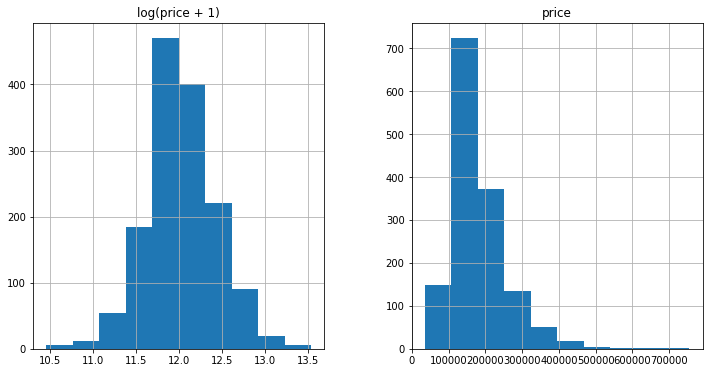

In [134]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()
prices.head()

In [135]:
prices.shape

(1460, 2)

In [136]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

In [137]:
numeric_feats = all_X.dtypes[all_X.dtypes != "object"].index

In [138]:
type(numeric_feats)

pandas.core.indexes.base.Index

In [139]:
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats

MSSubClass        1.406210
LotFrontage       2.160866
LotArea          12.195142
OverallQual       0.216721
OverallCond       0.692355
YearBuilt        -0.612831
YearRemodAdd     -0.503044
MasVnrArea        2.666326
BsmtFinSF1        1.683771
BsmtFinSF2        4.250888
BsmtUnfSF         0.919323
TotalBsmtSF       1.522688
1stFlrSF          1.375342
2ndFlrSF          0.812194
LowQualFinSF      9.002080
GrLivArea         1.365156
BsmtFullBath      0.595454
BsmtHalfBath      4.099186
FullBath          0.036524
HalfBath          0.675203
BedroomAbvGr      0.211572
KitchenAbvGr      4.483784
TotRmsAbvGrd      0.675646
Fireplaces        0.648898
GarageYrBlt      -0.648708
GarageCars       -0.342197
GarageArea        0.179796
WoodDeckSF        1.539792
OpenPorchSF       2.361912
EnclosedPorch     3.086696
3SsnPorch        10.293752
ScreenPorch       4.117977
PoolArea         14.813135
MiscVal          24.451640
MoSold            0.211835
YrSold            0.096170
dtype: float64

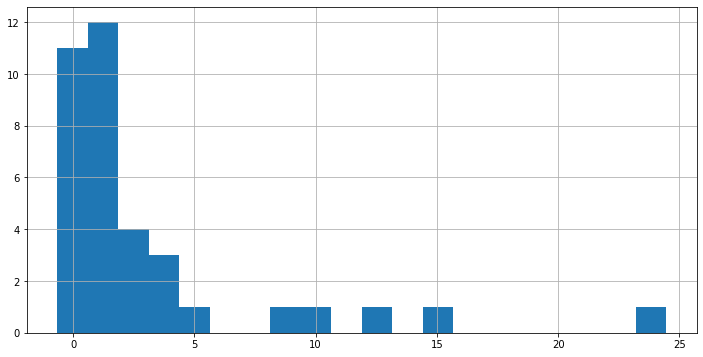

In [140]:
skewed_feats.hist(bins=20)

In [141]:
skewed_feats[skewed_feats > 0.75]

MSSubClass        1.406210
LotFrontage       2.160866
LotArea          12.195142
MasVnrArea        2.666326
BsmtFinSF1        1.683771
BsmtFinSF2        4.250888
BsmtUnfSF         0.919323
TotalBsmtSF       1.522688
1stFlrSF          1.375342
2ndFlrSF          0.812194
LowQualFinSF      9.002080
GrLivArea         1.365156
BsmtHalfBath      4.099186
KitchenAbvGr      4.483784
WoodDeckSF        1.539792
OpenPorchSF       2.361912
EnclosedPorch     3.086696
3SsnPorch        10.293752
ScreenPorch       4.117977
PoolArea         14.813135
MiscVal          24.451640
dtype: float64

In [142]:
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
skewed_feats

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

In [143]:
all_X[skewed_feats] 

,MSSubClass,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,GrLivArea,BsmtHalfBath,KitchenAbvGr,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,60,65.0,8450,196.0,706.0,0.0,150.0,856.0,856,854,...,1710,0.0,1,0,61,0,0,0,0,0
1,20,80.0,9600,0.0,978.0,0.0,284.0,1262.0,1262,0,...,1262,1.0,1,298,0,0,0,0,0,0
2,60,68.0,11250,162.0,486.0,0.0,434.0,920.0,920,866,...,1786,0.0,1,0,42,0,0,0,0,0
3,70,60.0,9550,0.0,216.0,0.0,540.0,756.0,961,756,...,1717,0.0,1,0,35,272,0,0,0,0
4,60,84.0,14260,350.0,655.0,0.0,490.0,1145.0,1145,1053,...,2198,0.0,1,192,84,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,21.0,1936,0.0,0.0,0.0,546.0,546.0,546,546,...,1092,0.0,1,0,0,0,0,0,0,0
1455,160,21.0,1894,0.0,252.0,0.0,294.0,546.0,546,546,...,1092,0.0,1,0,24,0,0,0,0,0
1456,20,160.0,20000,0.0,1224.0,0.0,0.0,1224.0,1224,0,...,1224,0.0,1,474,0,0,0,0,0,0
1457,85,62.0,10441,0.0,337.0,0.0,575.0,912.0,970,0,...,970,1.0,1,80,32,0,0,0,0,700


In [144]:
numeric_data = all_X[skewed_feats]

In [145]:
np.log1p(numeric_data).isnull().sum()

/Users/JK/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log1p
  """Entry point for launching an IPython kernel.


MSSubClass         0
LotFrontage      486
LotArea            0
MasVnrArea        23
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtHalfBath       2
KitchenAbvGr       0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
dtype: int64

In [146]:
np.log1p(numeric_data)

/Users/JK/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log1p
  """Entry point for launching an IPython kernel.


,MSSubClass,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,GrLivArea,BsmtHalfBath,KitchenAbvGr,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,4.110874,4.189655,9.042040,5.283204,6.561031,0.0,5.017280,6.753438,6.753438,6.751101,...,7.444833,0.000000,0.693147,0.000000,4.127134,0.000000,0.0,0.0,0.0,0.000000
1,3.044522,4.394449,9.169623,0.000000,6.886532,0.0,5.652489,7.141245,7.141245,0.000000,...,7.141245,0.693147,0.693147,5.700444,0.000000,0.000000,0.0,0.0,0.0,0.000000
2,4.110874,4.234107,9.328212,5.093750,6.188264,0.0,6.075346,6.825460,6.825460,6.765039,...,7.488294,0.000000,0.693147,0.000000,3.761200,0.000000,0.0,0.0,0.0,0.000000
3,4.262680,4.110874,9.164401,0.000000,5.379897,0.0,6.293419,6.629363,6.869014,6.629363,...,7.448916,0.000000,0.693147,0.000000,3.583519,5.609472,0.0,0.0,0.0,0.000000
4,4.110874,4.442651,9.565284,5.860786,6.486161,0.0,6.196444,7.044033,7.044033,6.960348,...,7.695758,0.000000,0.693147,5.262690,4.442651,0.000000,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,5.081404,3.091042,7.568896,0.000000,0.000000,0.0,6.304449,6.304449,6.304449,6.304449,...,6.996681,0.000000,0.693147,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
1455,5.081404,3.091042,7.546974,0.000000,5.533389,0.0,5.686975,6.304449,6.304449,6.304449,...,6.996681,0.000000,0.693147,0.000000,3.218876,0.000000,0.0,0.0,0.0,0.000000
1456,3.044522,5.081404,9.903538,0.000000,7.110696,0.0,0.000000,7.110696,7.110696,0.000000,...,7.110696,0.000000,0.693147,6.163315,0.000000,0.000000,0.0,0.0,0.0,0.000000
1457,4.454347,4.143135,9.253591,0.000000,5.823046,0.0,6.356108,6.816736,6.878326,0.000000,...,6.878326,0.693147,0.693147,4.394449,3.496508,0.000000,0.0,0.0,0.0,6.552508


In [147]:
all_X[skewed_feats] = np.log1p(numeric_data)

/Users/JK/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log1p
  """Entry point for launching an IPython kernel.


In [148]:
all_X[skewed_feats].head()

,MSSubClass,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,GrLivArea,BsmtHalfBath,KitchenAbvGr,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,4.110874,4.189655,9.042040,5.283204,6.561031,0.0,5.017280,6.753438,6.753438,6.751101,...,7.444833,0.000000,0.693147,0.000000,4.127134,0.000000,0.0,0.0,0.0,0.0
1,3.044522,4.394449,9.169623,0.000000,6.886532,0.0,5.652489,7.141245,7.141245,0.000000,...,7.141245,0.693147,0.693147,5.700444,0.000000,0.000000,0.0,0.0,0.0,0.0
2,4.110874,4.234107,9.328212,5.093750,6.188264,0.0,6.075346,6.825460,6.825460,6.765039,...,7.488294,0.000000,0.693147,0.000000,3.761200,0.000000,0.0,0.0,0.0,0.0
3,4.262680,4.110874,9.164401,0.000000,5.379897,0.0,6.293419,6.629363,6.869014,6.629363,...,7.448916,0.000000,0.693147,0.000000,3.583519,5.609472,0.0,0.0,0.0,0.0
4,4.110874,4.442651,9.565284,5.860786,6.486161,0.0,6.196444,7.044033,7.044033,6.960348,...,7.695758,0.000000,0.693147,5.262690,4.442651,0.000000,0.0,0.0,0.0,0.0


In [149]:
all_X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,4.110874,RL,4.189655,9.042040,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0.0,0.0,NaN,NaN,NaN,0.0,2,2008,WD,Normal
1,3.044522,RL,4.394449,9.169623,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0.0,0.0,NaN,NaN,NaN,0.0,5,2007,WD,Normal
2,4.110874,RL,4.234107,9.328212,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0.0,0.0,NaN,NaN,NaN,0.0,9,2008,WD,Normal
3,4.262680,RL,4.110874,9.164401,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0.0,0.0,NaN,NaN,NaN,0.0,2,2006,WD,Abnorml
4,4.110874,RL,4.442651,9.565284,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0.0,0.0,NaN,NaN,NaN,0.0,12,2008,WD,Normal


In [150]:
all_X.shape

(2919, 79)

In [151]:
#Create Dummy variables for the categorical features

all_X = pd.get_dummies(all_X)

all_X.shape

(2919, 288)

In [152]:
all_X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,0.0,...,0,0,0,1,0,0,0,0,1,0
1,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,0.0,...,0,0,0,1,0,0,0,0,1,0
2,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,0.0,...,0,0,0,1,0,0,0,0,1,0
3,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,0.0,...,0,0,0,1,1,0,0,0,0,0
4,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,0.0,...,0,0,0,1,0,0,0,0,1,0


In [153]:
#filling NA's with the mean of the column:
all_X = all_X.fillna(all_X.mean())

In [154]:
#creating matrices for sklearn:
X_train = all_X[:train.shape[0]]
X_test = all_X[train.shape[0]:]
y_train = train.SalePrice

In [155]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,0.0,...,0,0,0,1,0,0,0,0,1,0
1,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,0.0,...,0,0,0,1,0,0,0,0,1,0
2,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,0.0,...,0,0,0,1,0,0,0,0,1,0
3,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,0.0,...,0,0,0,1,1,0,0,0,0,0
4,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,0.0,...,0,0,0,1,0,0,0,0,1,0


In [156]:
y_train.head()

0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
Name: SalePrice, dtype: float64

In [157]:
X_train.shape

(1460, 288)

In [158]:
X_test.shape

(1459, 288)

In [159]:
y_train.shape

(1460,)

# Predictive Modeling

Now we are going to use regularized linear regression models from the scikit learn module. I'm going to try both l_1(Lasso) and l_2(Ridge) regularization. I'll also define a function that returns the cross-validation rmse error so we can evaluate our models and pick the best tuning hyperparameters

In [160]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)


In [162]:
#Validation function with random shuffle
n_folds = 5
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [163]:
model_ridge = Ridge()

In [164]:
model_ridge.fit(X_train,y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

The main tuning parameter for the Ridge model is alpha - a regularization parameter that measures how flexible our model is. The higher the regularization the less prone our model will be to overfit. However it will also lose flexibility and might not capture all of the signal in the data.

In [165]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean()
            for alpha in alphas]
            

In [166]:
cv_ridge

[0.13893637694024513,
 0.13777538277187878,
 0.13501433618086014,
 0.13136184989399582,
 0.12864892446111878,
 0.12782179689257286,
 0.12733734668670774,
 0.12752940439753804,
 0.12895888148450046,
 0.13099437857191423,
 0.13316366423370257]

Text(0.5, 0, 'alpha')

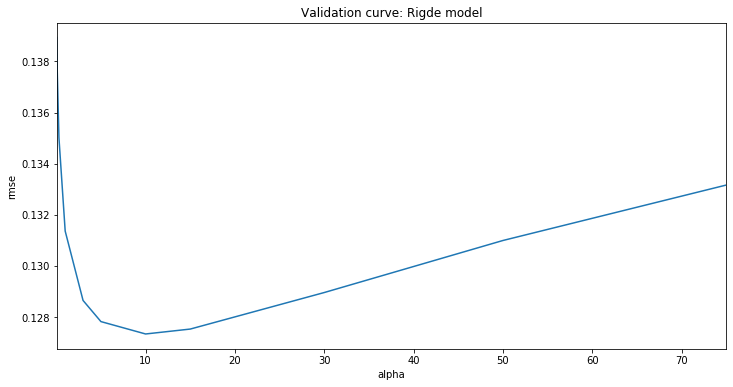

In [167]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation curve: Rigde model")

plt.ylabel("rmse")
plt.xlabel("alpha")

Note the U-ish shaped curve above. When alpha is too large the regularization is too strong and the model cannot capture all the complexities in the data. If however we let the model be too flexible (alpha small) the model begins to overfit. A value of alpha = 10 is about right based on the plot above.

In [168]:
cv_ridge.min()

0.12733734668670774

So for the Ridge regression we get a rmsle of about 0.127

Let' try out the Lasso model. I will do a slightly different approach here and use the built in Lasso CV to figure out the best alpha. 

In [169]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005], cv= 3).fit(X_train, y)

In [170]:
model_lasso

LassoCV(alphas=[1, 0.1, 0.001, 0.0005], copy_X=True, cv=3, eps=0.001,
        fit_intercept=True, max_iter=1000, n_alphas=100, n_jobs=None,
        normalize=False, positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [171]:
rmse_cv(model_lasso)

array([0.10330973, 0.13147319, 0.12552436, 0.10818879, 0.14722499])

In [172]:
rmse_cv(model_lasso).mean()

0.12314421090977432

In [173]:
model_lasso.alphas

[1, 0.1, 0.001, 0.0005]

In [174]:
# chosen alpha after hyperparameter tuning
model_lasso.alpha_

0.0005

Nice! The lasso performs even better so we'll just use this one to predict on the test set. Another neat thing about the Lasso is that it does feature selection for you - setting coefficients of features it deems unimportant to zero. Let's take a look at the coefficients:

In [175]:
# store lasso coefficients
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [176]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 110 variables and eliminated the other 178 variables


Good job Lasso.  One thing to note here however is that the features selected are not necessarily the "correct" ones - especially since there are a lot of collinear features in this dataset. One idea to try here is run Lasso a few times on boostrapped samples and see how stable the feature selection is.

We can also take a look directly at what the most important coefficients are:

In [177]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

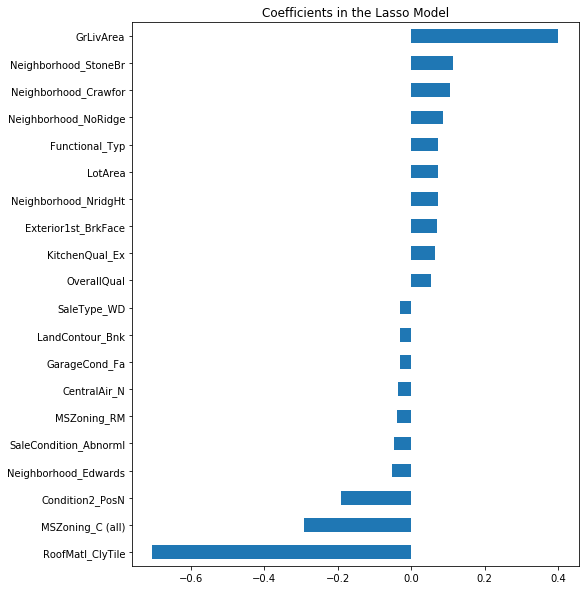

In [178]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

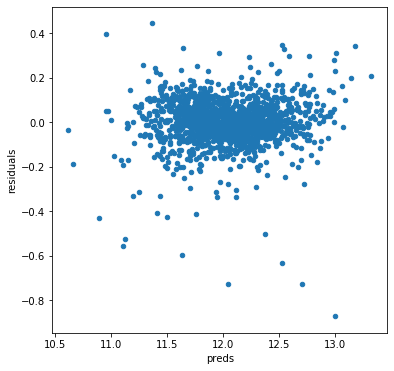

In [179]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

## Lasso, eNet, Ridge, boost models (with pipeline)

Now let's try some other models as well
- random forest
- gradient boost
- xgboost
- lightgbm

In [181]:
# lasso, ENet, KRR, GBoost, model_xgb, model_lgb
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

### validation scores

In [182]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))


Lasso score: 0.1226 (0.0162)

ElasticNet score: 0.1226 (0.0163)

Kernel Ridge score: 0.1684 (0.0193)

Gradient Boosting score: 0.1239 (0.0133)



/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None a

Xgboost score: 0.1227 (0.0103)

LGBM score: 0.1234 (0.0111)



We could see, the boosting models are performing around the the same level as our regularized regression models

In [183]:
rmsle_cv(lasso)

array([0.10321219, 0.13149904, 0.12558838, 0.10595377, 0.14660296])

In [184]:
rmse_cv(lasso)

array([0.10321219, 0.13149904, 0.12558838, 0.10595377, 0.14660296])

In [185]:
rmse_cv(model_lasso)

array([0.10330973, 0.13147319, 0.12552436, 0.10818879, 0.14722499])

In [186]:
rmse_cv(lasso).mean() - rmse_cv(model_lasso).mean()

-0.0005729409104230088

# Plot residuals of prediction under different models

we need to fit models first

In [187]:
lasso.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('lasso',
                 Lasso(alpha=0.0005, copy_X=True, fit_intercept=True,
                       max_iter=1000, normalize=False, positive=False,
                       precompute=False, random_state=1, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         verbose=False)

In [188]:
ENet.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('elasticnet',
                 ElasticNet(alpha=0.0005, copy_X=True, fit_intercept=True,
                            l1_ratio=0.9, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=3,
                            selection='cyclic', tol=0.0001,
                            warm_start=False))],
         verbose=False)

In [189]:
KRR.fit(X_train, y_train)

KernelRidge(alpha=0.6, coef0=2.5, degree=2, gamma=None, kernel='polynomial',
            kernel_params=None)

In [190]:
GBoost.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.05, loss='huber', max_depth=4,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=15, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=3000,
                          n_iter_no_change=None, presort='auto', random_state=5,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [191]:
model_xgb.fit(X_train, y_train)

/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/JK/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4603, gamma=0.0468,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1.7817, missing=None,
             n_estimators=2200, n_jobs=1, nthread=-1, objective='reg:linear',
             random_state=7, reg_alpha=0.464, reg_lambda=0.8571,
             scale_pos_weight=1, seed=None, silent=1, subsample=0.5213,
             verbosity=1)

In [192]:
model_lgb.fit(X_train, y_train)

LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.2319, feature_fraction_seed=9,
              importance_type='split', learning_rate=0.05, max_bin=55,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_data_in_leaf=6, min_split_gain=0.0,
              min_sum_hessian_in_leaf=11, n_estimators=720, n_jobs=-1,
              num_leaves=5, objective='regression', random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

Let's makes some plot

In [193]:
# define a function wrapper 
def plot_prdiction_residual(model):
    preds = pd.DataFrame({"preds":model.predict(X_train), "true":y_train})
    preds["residuals"] = preds["true"] - preds["preds"]
    preds.plot(x = "preds", y = "residuals",kind = "scatter", ylim=(-1, 0.5),title="Prediction vs Residual:")
    return

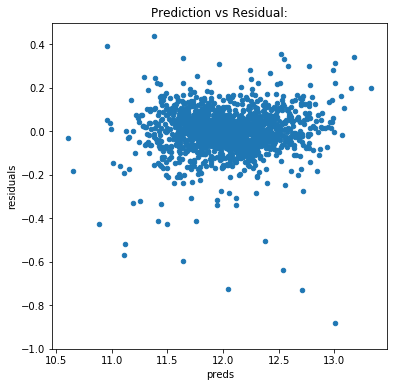

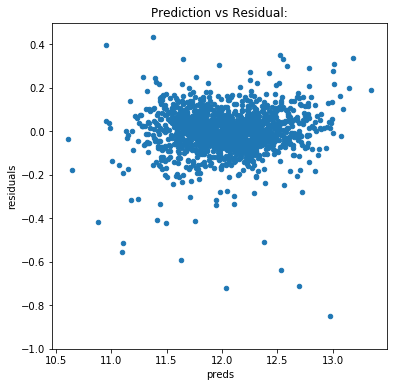

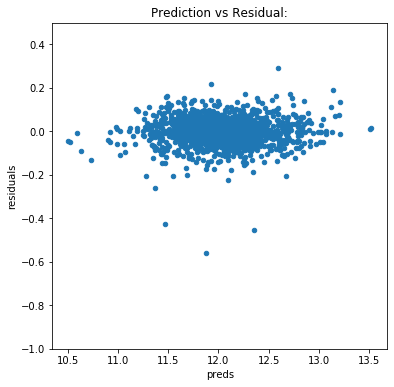

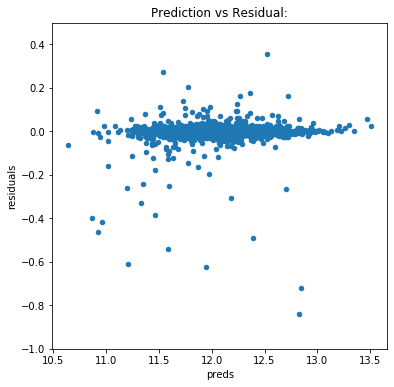

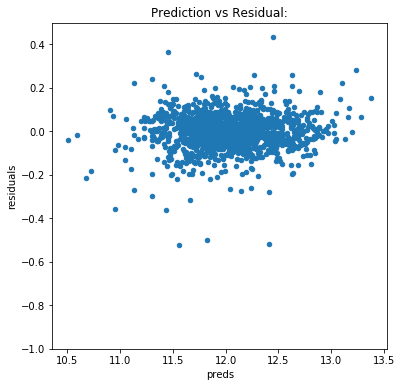

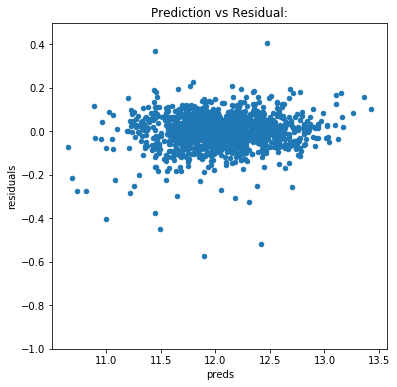

In [194]:
models = [lasso, ENet, KRR, GBoost, model_xgb, model_lgb]
for i in models:
    plot_prdiction_residual(i)

## Final Training and Prediction

In [195]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [196]:
lasso_train_pred = model_lasso.predict(X_train)
lasso_pred = np.expm1(model_lasso.predict(X_test))
print(rmsle(y_train, lasso_train_pred))

0.10502578262123977


In [197]:
lasso_train_pred = lasso.predict(X_train)
lasso_pred = np.expm1(lasso.predict(X_test))
print(rmsle(y_train, lasso_train_pred))

0.10497900918329381


In [198]:
ENet_train_pred = ENet.predict(X_train)
ENet_pred = np.expm1(ENet.predict(X_test))
print(rmsle(y_train, ENet_train_pred))

0.10403585205697068


In [199]:
KRR_train_pred = KRR.predict(X_train)
KRR_pred = np.expm1(KRR.predict(X_test))
print(rmsle(y_train, KRR_train_pred))

0.06182032482052553


In [200]:
GBoost_train_pred = GBoost.predict(X_train)
GBoost_pred = np.expm1(GBoost.predict(X_test))
print(rmsle(y_train, GBoost_train_pred))

0.058206184283354126


In [201]:

xgb_train_pred = model_xgb.predict(X_train)
xgb_pred = np.expm1(model_xgb.predict(X_test))
print(rmsle(y_train, xgb_train_pred))

0.07929070742478252


In [202]:

lgb_train_pred = model_lgb.predict(X_train)
lgb_pred = np.expm1(model_lgb.predict(X_test))
print(rmsle(y_train, lgb_train_pred))

0.07478606015269969


### Ensemble prediction

In [203]:
ensemble = GBoost_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15


## Submission

In [209]:
ensemble.shape

(1459,)

In [210]:

sub = pd.DataFrame()
sub['Id'] = test['Id']
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)
